# 이미지를 numpy 배열로 만들고 저장하기

In [2]:
import pathlib
import os,glob
import numpy as np
from PIL import Image

from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.utils import to_categorical

# 이미지를 numpy 배열로 만들기

np.random.seed(42)

directory = 'C:/Users/s_csmscox/jupyterSave/dvc/train'
categories = ["0","1"] # dog = 1, cat = 0
nb_classes = len(categories)

w = 224
h = 224

X = []
y = []

for idx, obj in enumerate(categories):

    image_dir = directory + "/" + obj
    files = glob.glob(image_dir+"/*.jpg")
    print(obj, " 파일 길이 : ", len(files))
    
    for i, f in enumerate(files):
        img = Image.open(f)
        
        # 사이즈 조절
        img = img.resize((w, h))
        
        img = np.asarray(img)
        img = img.reshape(w,h,3)

        X.append(img)
        y.append(idx)

        if i % 10000 == 0:
            print(obj, " : ", f)


0  파일 길이 :  12500
0  :  C:/Users/s_csmscox/jupyterSave/dvc/train/0\cat.0.jpg
0  :  C:/Users/s_csmscox/jupyterSave/dvc/train/0\cat.7749.jpg
1  파일 길이 :  12500
1  :  C:/Users/s_csmscox/jupyterSave/dvc/train/1\dog.0.jpg
1  :  C:/Users/s_csmscox/jupyterSave/dvc/train/1\dog.7749.jpg


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

del X
del y

X_train = np.array(X_train)
X_train = X_train/255
np.save("C:/Users/s_csmscox/jupyterSave/dvc/X_train224.npy", X_train)
del X_train

X_test = np.array(X_test)
X_test = X_test/255
np.save("C:/Users/s_csmscox/jupyterSave/dvc/X_test224.npy", X_test)
del X_test

# y_train = np.array(y_train)
# y_train = to_categorical(y_train)
# np.save("C:/Users/s_csmscox/jupyterSave/dvc/y_train.npy", y_train)
# del y_train

# y_test = np.array(y_test)
# y_test = to_categorical(y_test)
# np.save("C:/Users/s_csmscox/jupyterSave/dvc/y_test.npy", y_test)
# del y_test

# numpy 배열을 부러와서 모델 학습 및 저장

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.applications import VGG16

np.random.seed(42)

X_train = np.load('C:/Users/s_csmscox/jupyterSave/dvc/X_train224.npy')
y_train = np.load('C:/Users/s_csmscox/jupyterSave/dvc/y_train.npy')
# y_train_binary = np.load('y_train_binary.npy')

In [3]:
# Image Augmentation

img_gen = ImageDataGenerator(rotation_range=20,  # 지정된 각도 범위내에서 임의로 원본 이미지를 회전
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,    #  1-수치 혹은 1+수치만큼 확대 및 축소
                                   horizontal_flip=True,
                                   vertical_flip=False)

augment_size = 10000

randidx = np.random.randint(X_train.shape[0], size=augment_size)
x_augment = X_train[randidx].copy()
y_augment = y_train[randidx].copy()
x_augment = img_gen.flow(x_augment, np.zeros(augment_size),
                        batch_size=augment_size, shuffle=False).next()[0]

X_train = np.concatenate((X_train, x_augment))
y_train = np.concatenate((y_train, y_augment))

print(X_train.shape)

(30000, 224, 224, 3)


In [4]:
#모델 구축

# vgg16 모델 불러오기
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()

# vgg16 모델에 덧붙이기
model = Sequential()
model.add(pre_trained_vgg)
model.add(Flatten())
model.add(Dense(4096, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(2048, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))

model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-7), loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#모델 학습
early_stopping = EarlyStopping(patience = 5) # 조기종료 콜백함수 정의

history = model.fit(X_train, y_train, epochs=100, verbose=1,
                   validation_split=0.2, batch_size=10, callbacks=[early_stopping])

Epoch 1/100
2400/2400 [==============================] - 177s 74ms/step - loss: 0.5279 - accuracy: 0.7610 - val_loss: 0.4497 - val_accuracy: 0.8233
Epoch 2/100
2400/2400 [==============================] - 119s 49ms/step - loss: 0.3586 - accuracy: 0.8674 - val_loss: 0.3625 - val_accuracy: 0.8575
Epoch 3/100
2400/2400 [==============================] - 117s 49ms/step - loss: 0.2948 - accuracy: 0.8899 - val_loss: 0.3194 - val_accuracy: 0.8742
Epoch 4/100
2400/2400 [==============================] - 117s 49ms/step - loss: 0.2598 - accuracy: 0.9018 - val_loss: 0.2925 - val_accuracy: 0.8832
Epoch 5/100
2400/2400 [==============================] - 117s 49ms/step - loss: 0.2365 - accuracy: 0.9103 - val_loss: 0.2737 - val_accuracy: 0.8883
Epoch 6/100
2400/2400 [==============================] - 117s 49ms/step - loss: 0.2191 - accuracy: 0.9161 - val_loss: 0.2592 - val_accuracy: 0.8928
Epoch 7/100
2400/2400 [==============================] - 117s 49ms/step - loss: 0.2051 - accuracy: 0.9228 - val_

2400/2400 [==============================] - 124s 52ms/step - loss: 0.0470 - accuracy: 0.9919 - val_loss: 0.1464 - val_accuracy: 0.9405
Epoch 53/100
2400/2400 [==============================] - 123s 51ms/step - loss: 0.0454 - accuracy: 0.9926 - val_loss: 0.1474 - val_accuracy: 0.9395
Epoch 54/100
2400/2400 [==============================] - 124s 52ms/step - loss: 0.0437 - accuracy: 0.9936 - val_loss: 0.1446 - val_accuracy: 0.9412
Epoch 55/100
2400/2400 [==============================] - 124s 52ms/step - loss: 0.0422 - accuracy: 0.9941 - val_loss: 0.1454 - val_accuracy: 0.9415
Epoch 56/100
2400/2400 [==============================] - 123s 51ms/step - loss: 0.0408 - accuracy: 0.9942 - val_loss: 0.1462 - val_accuracy: 0.9403
Epoch 57/100
 947/2400 [==========>...................] - ETA: 1:04 - loss: 0.0390 - accuracy: 0.9949

In [ ]:
# 학습 곡선을 나타내는 함수
def plot_loss_curve(history):
    plt.figure(figsize=(15, 10))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train loss=", history.history['loss'][-1])
    print("validation loss=", history.history['val_loss'][-1])
    
def plot_acc_curve(history):
    plt.figure(figsize=(15, 10))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train accuracy=", history.history['accuracy'][-1])
    print("validation accuracy=", history.history['val_accuracy'][-1])
    
plot_loss_curve(history)
plot_acc_curve(history)

In [ ]:
model.save('C:/Users/s_csmscox/jupyterSave/dvc/dvc_vgg16_224_augment')

# 모델 불러와서 성능 평가

In [2]:
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('C:/Users/s_csmscox/jupyterSave/dvc/dvc02')

In [10]:
X_test = np.load('C:/Users/s_csmscox/jupyterSave/dvc/X_test224.npy')
y_test = np.load('C:/Users/s_csmscox/jupyterSave/dvc/y_test.npy')

In [11]:
# 모델 평가
print("-- Evaluate --")
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
157/157 [==============================] - 10s 67ms/step - loss: 0.1552 - accuracy: 0.9362
accuracy: 93.62%


In [12]:
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import classification_report

#y_pred와 y_test를 일차원 배열로 만드는 함수
def y_to_list(y_pred, y_test):
    yp = []
    yt = []
    for i in y_pred:
        idx = 0
        m = 0
        for j in range(0,2):
            if(i[j]>m):
                m = i[j]
                idx = j
        yp.append(idx)
    
    for i in y_test:
        idx = 0
        for j in range(0,2):
            if(i[j]==1):
                idx = j
                break
        yt.append(idx)
    
    return yp, yt

#모델 예측 및 classification_report를 통한 평가
y_pred = model.predict(X_test)

yp, yt = y_to_list(y_pred, y_test)

target_names = ['cat', 'dog']
print(classification_report(yt, yp, target_names=target_names))

              precision    recall  f1-score   support

         cat       0.93      0.94      0.94      2515
         dog       0.94      0.93      0.94      2485

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



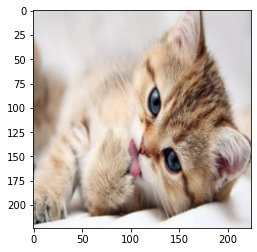

예측 : 고양이


In [13]:
img = Image.open('C:/Users/s_csmscox/jupyterSave/cat.jpg')

img = img.resize((224,224))
        
img = np.asarray(img)
img = img.reshape(224,224,3)

plt.imshow(img)
plt.show()

img = img/255

img = img.reshape(1,224,224,3)
pred = model.predict(img)

for i in pred:
    m = i.max()
    for j in range(2):
        if i[j] == m:
            if j == 0:
                print("예측 : 고양이")
            else:
                print("예측 : 강아지")


In [ ]:
# sigmoid
# 모델 평가
print("-- Evaluate --")
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

img = Image.open('C:/Users/s_csmscox/jupyterSave/cat.jpg')

img = img.resize((128,128))
        
img = np.asarray(img)
img = img.reshape(128,128,3)

plt.imshow(img)
plt.show()

img = img/255

img = img.reshape(1,128,128,3)
pred = model.predict(img)

if pred == 0:
    print("예측 : 고양이")
else:
    print("예측 : 강아지")